In [60]:
# Ran on pysr environment
%pylab inline
import matplotlib.pyplot as plt
from tqdm import trange
from abess.linear import LinearRegression
from sklearn.metrics import mean_squared_error
from utils import BIC_AIC

import numpy as np; np.random.seed(0)
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from numpy.fft import fft, ifft, fftfreq
from time import time

fontsize = 20

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['fft', 'time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [61]:
def parametric_burgers_rhs(u, t, params):
    k,a,b,c = params
    deriv = a*(1+c*np.sin(t))*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u))
    return real(deriv)

In [62]:
# Set size of grid
n = 256
m = 256

# Set up grid
x = np.linspace(-8,8,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,10,m);          dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x+1)**2)

# Solve with time dependent uu_x term
params = (k, -1, 0.1, 0.25)
u = odeint(parametric_burgers_rhs, u0, t, args=(params,)).T

u_xx_true = 0.1*np.ones(m)
uu_x_true = -1*(1+0.25*np.sin(t))

In [63]:
# # Plot
# fig = plt.figure(figsize=(8,5))
# X, T = np.meshgrid(x, t)
# plt.contourf(X, T, u.T, levels=40, cmap='coolwarm')
# plt.colorbar()
# plt.xlabel('x', fontsize=fontsize)
# plt.ylabel('t', fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.xlim([x[0],x[-1]])
# plt.savefig("/Users/pongpisit/Documents/figure_export/parametric_burgers_equation_solution.pdf")
# plt.show()

In [64]:
# fig = plt.figure(figsize=(8,5))
# plt.plot(t, uu_x_true, label=r'$uu_{x}$')
# plt.plot(t, u_xx_true, label=r'$u_{xx}$')
# plt.xticks(fontsize = fontsize)
# plt.yticks(fontsize = fontsize)
# plt.xlim([t[0],t[-1]])
# plt.savefig("/Users/pongpisit/Documents/figure_export/parametric_burgers_equation_coefficients.pdf")
# plt.show()

#### Noiseless

In [65]:
# u, E1 = RobustPCA(u, lam_2=10)
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'FD', space_diff = 'FD')

# Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
# Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

#### std Noise

In [66]:
noise_lv = 6
u = u + 0.01*float(noise_lv)*std(u)*np.random.randn(n,m)

# u, E1 = RobustPCA(u, lam_2=10)

# Build linear systems
wx = 10
wt = 10

Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, time_diff = 'poly',
                                       deg_x = 6, deg_t = 4, 
                                       width_x = wx, width_t = wt)
Theta = Theta[:, 1:]; rhs_des = rhs_des[1:] # removing the constant term...
n = n - 2*wx
m = m - 2*wt

# Group by timestep
Theta_grouped = [real(Theta[j*n:(j+1)*n,:]) for j in range(m)]
Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

In [67]:
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:596: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  candidate_norms[i] = Norm(np.vstack(A[:,i] for A in As), normalize)
/Users/pongpisit/Desktop/research/parametric-discovery/parametric_pde_find.py:566: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  W[biginds,i] = np.linalg.lstsq(Xs[i][:, biginds],ys[i])[0].reshape(len(biginds))


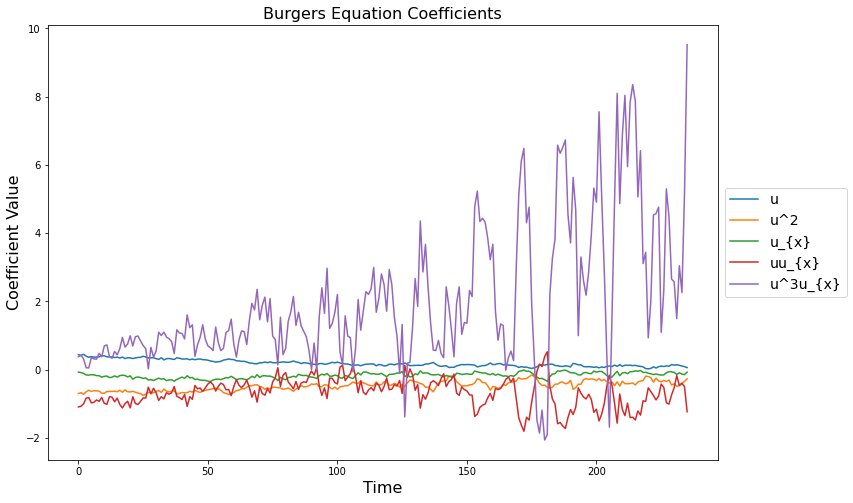

0.0008529684151613319


(349.5922168034296, 231.88864297934848)

In [68]:
stgridge_indices = []
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        stgridge_indices.append(j)
        plot(xi[j,:], label = rhs_des[j])
stgridge_indices = np.array(stgridge_indices)
title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()

consider = Theta[:, stgridge_indices]
xi = xi[stgridge_indices, :]
pred = np.zeros_like(Ut)
pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
print(mean_squared_error(pred, Ut))

ground = -0.25*np.sin(t)-1
errs = np.array([100*np.linalg.norm(xi[0, :]-ground[wt:-wt], 1)/np.linalg.norm(ground[wt:-wt], 1), 
                 100*(np.abs(xi[1, :].mean()-0.1))/0.1])
errs.mean(), errs.std()

In [69]:
bic_aic_scores = []; candidates = []
for com in range(1, len(stgridge_indices)+1):
    track = set(); min_perf = 1000; best_indices = (); best_ws = []
    for i in range(m):
        abess_model = LinearRegression(max_iter=100, support_size=com, path_type="seq", cv=5)
        abess_model.fit(Theta_grouped[i], Ut_grouped[i])
        indices = tuple(np.where(np.abs(abess_model.coef_) > 0)[0])
        if indices not in track:
            track.add(indices)
            ws = []; perf = []
            for j in range(m):
                w = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
                perf.append(mean_squared_error(Theta_grouped[j][:, indices]@w, Ut_grouped[j]))
                ws.append(w)
            perf = np.array(perf).mean()
            # print(indices, perf)
            if perf < min_perf:
                min_perf = perf
                best_indices = indices
                best_ws = ws
    xi = np.hstack(best_ws)
    candidates.append((best_indices, xi))
    print(best_indices, min_perf)
    # track info criterion
    consider = Theta[:, best_indices]
    pred = np.zeros_like(Ut)
    pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
    info_criterion = BIC_AIC(pred, Ut, com)
    bic_aic_scores.append(BIC_AIC(pred, Ut, com))

(3,) 0.0014410327503602816
(4, 8) 0.0011286930209633331
(2, 3, 4) 0.0010020799473678705
(2, 3, 4, 5) 0.0009687355341383726
(0, 1, 4, 5, 6) 0.0008503648640224872


In [75]:
bic_aic_scores

[(-206315.91623752122, -206324.84390113127),
 (-219911.50464136578, -219929.3599685859),
 (-226527.4294967182, -226554.21248754836),
 (-228401.333461202, -228437.0441156422),
 (-235649.0504286753, -235693.68874672556)]

In [76]:
print("best complexity")
bc = np.argmin(np.array([bic_aic_scores[i][0]-bic_aic_scores[i-1][0] for i in range(1, len(bic_aic_scores))]))+2
bc = np.argmin(np.array([bic_aic_scores[i][1]-bic_aic_scores[i-1][1] for i in range(1, len(bic_aic_scores))]))+2
best_indices = candidates[bc-1][0]
xi = candidates[bc-1][1]

best complexity


In [77]:
Theta_grouped = [real(Theta[j*n:(j+1)*n,:])[:, best_indices] for j in range(m)]
Ut_grouped = [real(Ut[j*n:(j+1)*n]) for j in range(m)]

In [78]:
# brute force solve for the best len(best_indices)-complexity signals

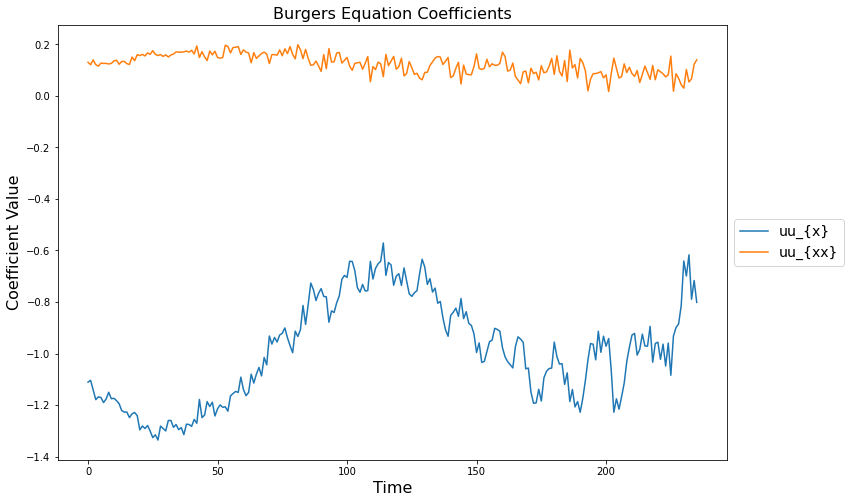

In [79]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        plot(xi[j,:], label = rhs_des[best_indices[j]])

title('Burgers Equation Coefficients', fontsize = 16)
xlabel('Time', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()

In [80]:
consider = Theta[:, best_indices]
pred = np.zeros_like(Ut)
pred = np.array([consider[:, i:i+1]*xi[i].repeat(n).reshape(-1, 1) for i in range(len(xi))]).sum(axis=0)
mean_squared_error(pred, Ut)

0.001128693020963333

In [81]:
# ground = -0.25*np.sin(t)-1
# errs = np.array([100*np.linalg.norm(xi[5, :]-ground, 1)/np.linalg.norm(ground, 1), 
#                  100*(np.abs(xi[8, :].mean()-0.1))/0.1])

In [82]:
ground = -0.25*np.sin(t)-1
errs = np.array([100*np.linalg.norm(xi[0, :]-ground[wt:-wt], 1)/np.linalg.norm(ground[wt:-wt], 1), 
                 100*(np.abs(xi[1, :].mean()-0.1))/0.1])
errs.mean(), errs.std()

(15.858301811008296, 7.813491274666734)